<a href="https://colab.research.google.com/github/tongnamuu/ReinforcementLearning/blob/master/%5BModel_based%5D_Dyna_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycolab

     |████████████████████████████████| 174kB 7.8MB/s 


In [ ]:
#@title
# Author: Andre Cianflone
# Some code Based on:
# https://github.com/deepmind/pycolab/blob/master/pycolab/examples/classics/four_rooms.py
# Added wrapper so behaves more like gym

import curses
import sys

from pycolab import ascii_art
from pycolab import human_ui
from pycolab.prefab_parts import sprites as prefab_sprites
# from gym import spaces
import numpy as np


BLOCKING_MAZE1 = ['############',
                  '#          #',
                  '#          #',
                  '#          #',
                  '########## #',
                  '#          #',
                  '#   P      #',
                  '############']

class Discrete():
  def __init__(self, n):
    self.n = n # number of actions

  def sample(self):
    return np.random.randint(0,self.n)

class Maze(object):
  def __init__(self):
    """"""

  def make(self, map):
    return Gymify(map)

class Box():
  def __init__(self,low,high,shape,dtype):
    self.low = low
    self.high = high
    self.shape = shape
    self.dtype = dtype
    self.n = self.shape # number of states

class Gymify():
  """ Create Gym like environment """

  def __init__(self, map):
    self.map = map
    self.engine = self.new_engine()
    self.last_obs = None

    # These should come from gym.spaces, but to speed up colab, they are internal
    self.action_space = Discrete(4)
    self.observation_space = Box(
        low=0,
        high=1,
        shape=self.engine.rows*self.engine.cols,
        dtype='uint8'
        )

  def new_engine(self):
    return ascii_art.ascii_art_to_game(self.map, what_lies_beneath=' ',
                                                  sprites={'P': PlayerSprite})
  def reset(self):
    """ Reset game engine """
    self.engine = self.new_engine()
    obs, reward, gamma = self.engine.its_showtime();
    obs = self.observation_to_state(obs)
    return obs

  def step(self, move):
    """ Returns gym style step """
    # Get data from game engine
    obs, reward, gamma = self.engine.play(move)
    # Save the last observation in case of rendering
    self.last_obs = obs
    done = self.engine.game_over
    # Format other vars
    if reward == None: reward = 0
    info = ""
    # Format observation into proper state for RL
    obs = self.observation_to_state(obs)
    return obs, reward, done, info

  def observation_to_state(self, obs):
    """
    Given a Pycolab Observation object, encode to a state representation,
    which is basically the agent's current position in the board
    """
    arr = np.array(obs.layers['P'], dtype=np.float).flatten()
    return np.argmax(arr)

  def render(self):
    """ Render the last observation """
    for row in self.last_obs.board: print(row.tostring().decode('ascii'))

  # def __getattr__(self, name):
    # """ For unknown attr, try engine"""
    # self.engine.__dict__[name]

class PlayerSprite(prefab_sprites.MazeWalker):
  """A `Sprite` for our player.
  This `Sprite` ties actions to going in the four cardinal directions. If we
  reach a magical location (in this example, (4, 3)), the agent receives a
  reward of 1 and the epsiode terminates.
  """

  def __init__(self, corner, position, character):
    """Inform superclass that we can't walk through walls."""
    super(PlayerSprite, self).__init__(
        corner, position, character, impassable='#')

  def update(self, actions, board, layers, backdrop, things, the_plot):
    del layers, backdrop, things   # Unused.

    # Apply motion commands.
    if actions == 0:    # walk upward?
      self._north(board, the_plot)
    elif actions == 1:  # walk downward?
      self._south(board, the_plot)
    elif actions == 2:  # walk leftward?
      self._west(board, the_plot)
    elif actions == 3:  # walk rightward?
      self._east(board, the_plot)

    # See if we've found the mystery spot.
    if self.position == (1, 10):
      the_plot.add_reward(1.0)
      the_plot.terminate_episode()


/usr/local/lib/python3.6/dist-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


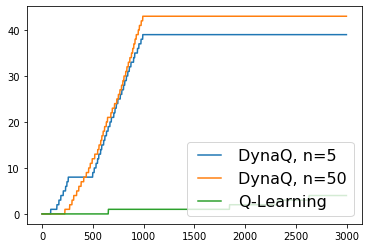

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

BLOCKING_MAZE1 = ['############',
                  '#          #',
                  '#          #',
                  '#          #',
                  '########## #',
                  '#          #',
                  '#   P      #',
                  '############']
BLOCKING_MAZE2 = ['############',
                  '#          #',
                  '#          #',
                  '#          #',
                  '# ##########',
                  '#          #',
                  '#   P      #',
                  '############']
class DynaQ():
  def __init__(self, game, n,alpha,gamma, epsilon, max_steps):
    self.game = game
    self.env = game.make(BLOCKING_MAZE1)
    self.q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
    self.epsilon = epsilon
    self.model =  Model(self.env.observation_space.n, self.env.action_space.n)
    self.n = n

  def learn(self):
    s = self.env.reset()
    cum_reward = [0]

    for step in range(max_steps):
      if np.random.uniform() < self.epsilon:
        a = self.env.action_space.sample()
      else:
        a = np.random.choice(np.where(self.q[s] == np.max(self.q[s]))[0])
      s_prime, r, done, info = self.env.step(a)

      self.q[s,a] += alpha*(r + gamma*np.max(self.q[s_prime]) - self.q[s,a])
      self.model.add(s,a,s_prime,r)
      self.planning()
      s = s_prime

      if done:
        s = self.env.reset()

      if step == 1000:
        self.env = self.game.make(BLOCKING_MAZE2)
        s = self.env.reset()
      cum_reward.append(cum_reward[-1] + r)
    return np.array(cum_reward[1:])

  def planning(self):
    for i in range(self.n):
      s, a =  self.model.sample()
      s_prime, r = self.model.step(s,a)
      self.q[s,a] += alpha*(r + gamma*np.max(self.q[s_prime]) - self.q[s,a])

class Model():
  def __init__(self, n_states, n_actions):
    self.transitions = np.zeros((n_states,n_actions), dtype=np.uint8)
    self.rewards = np.zeros((n_states, n_actions))

  def add(self,s,a,s_prime,r):
    self.transitions[s,a] = s_prime
    self.rewards[s,a] = r

  def sample(self):
    s = np.random.choice(np.where(np.sum(self.transitions, axis=1) > 0)[0])
    a = np.random.choice(np.where(self.transitions[s] > 0)[0])
    return s,a

  def step(self, s,a):
    s_prime = self.transitions[s,a]
    r = self.rewards[s,a]
    return s_prime, r


def plot_data(y):
  x = np.arange(y.size)
  _ = plt.plot(x, y, '-')
  plt.show()

def multi_plot_data(data, names):
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, '-', markersize=2, label=names[i])
  plt.legend(loc='lower right', prop={'size': 16}, numpoints=5)
  plt.show()

if __name__ == '__main__':
  alpha = 0.1
  gamma = 0.95
  epsilon = 0.3
  max_steps = 3000
  trials = 1

  dynaq_5_r = np.zeros((trials, max_steps))
  dynaq_50_r = np.zeros((trials, max_steps))
  qlearning_r = np.zeros((trials, max_steps))
  for t in range(trials):
    maze = Maze()

    n = 5
    agent = DynaQ(maze, n, alpha, gamma, epsilon, max_steps)
    dynaq_5_r[t] = agent.learn()

    n = 50
    agent = DynaQ(maze, n, alpha, gamma, epsilon, max_steps)
    dynaq_50_r[t] = agent.learn()

    n = 0
    agent = DynaQ(maze, n, alpha, gamma, epsilon, max_steps)
    qlearning_r[t] = agent.learn()

  dynaq_5_r = np.mean(dynaq_5_r, axis=0)
  dynaq_50_r = np.mean(dynaq_50_r, axis=0)
  qlearning_r = np.mean(qlearning_r, axis=0)

  data=[dynaq_5_r, dynaq_50_r, qlearning_r]
  names=["DynaQ, n=5", "DynaQ, n=50", "Q-Learning"]
  multi_plot_data(data,names)